In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
!pip -q install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip -q install geopandas rasterio rasterstats shapely
!pip -q install treeinterpreter

     |████████████████████████████████| 320 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 52.1 MB/s 
     |████████████████████████████████| 262 kB 62.0 MB/s 
     |████████████████████████████████| 167 kB 59.6 MB/s 
     |████████████████████████████████| 6.8 MB 26.2 MB/s 
     |████████████████████████████████| 1.7 MB 40.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 50.4 MB/s 
     |████████████████████████████████| 10.4 MB 21.3 MB/s 
     |████████████████████████████████| 120 kB 66.9 MB/s 
     |████████████████████████████████| 2.0 MB 55.4 MB/s 
     |████████████████████████████████| 17.8 MB 23.1 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 1.3 MB 2.5 MB/s 
     |█████████████████

In [6]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

In [8]:
import geopandas

training_vectors = geopandas.read_file('/content/drive/MyDrive/Varuna Hackathon 2022/training_area/traindata.shp')
print('Training Data')
training_vectors = training_vectors.rename(columns={"crop_type": "name"})
training_vectors = training_vectors.drop(columns=['years'], axis=0)
training_vectors.head()

Training Data


,name,geometry
0,1,"POLYGON ((774604.014 1671240.055, 774606.506 1..."
1,1,"POLYGON ((773367.837 1670278.438, 773389.600 1..."
2,1,"POLYGON ((771648.671 1673990.960, 771707.027 1..."
3,3,"POLYGON ((771306.117 1674174.738, 771426.678 1..."
4,2,"POLYGON ((763750.339 1678588.825, 763879.691 1..."


In [9]:
classes = np.array(['Cassava', 'Rice', 'Maize', 'Sugarcane'], dtype=object)
print(classes)

class_dict = {'1': 'Cassava',
              '2':'Rice',
              '3':'Maize',
              '4':'Sugarcane'}
print(class_dict)

['Cassava' 'Rice' 'Maize' 'Sugarcane']
{'1': 'Cassava', '2': 'Rice', '3': 'Maize', '4': 'Sugarcane'}


In [10]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm
b4 = glob('/content/drive/MyDrive/Varuna Hackathon 2022/sentinel-2-image/2021/*/IMG_DATA/**B04.jp2')
b6 = glob('/content/drive/MyDrive/Varuna Hackathon 2022/sentinel-2-image/2021/*/IMG_DATA/**B06.jp2')
b8 = glob('/content/drive/MyDrive/Varuna Hackathon 2022/sentinel-2-image/2021/*/IMG_DATA/**B08.jp2')
b11 = glob('/content/drive/MyDrive/Varuna Hackathon 2022/sentinel-2-image/2021/*/IMG_DATA/**B11.jp2')
b12 = glob('/content/drive/MyDrive/Varuna Hackathon 2022/sentinel-2-image/2021/*/IMG_DATA/**B12.jp2')
print(len(b4), len(b6), len(b8), len(b11), len(b12))

71 71 71 71 71


In [11]:
!mkdir datas
for i in tqdm(range(len(b4))):
    filename = b4[i].split('/')[-3]
    band4 = rasterio.open(b4[i], driver='JP2OpenJPEG') 
    band6 = rasterio.open(b6[i], driver='JP2OpenJPEG') 
    band8 = rasterio.open(b8[i], driver='JP2OpenJPEG')
    band11 = rasterio.open(b11[i], driver='JP2OpenJPEG')
    band12 = rasterio.open(b12[i], driver='JP2OpenJPEG')
    trueColor = rasterio.open(f'/content/datas/Sentinel2_{filename}.tiff','w',driver='Gtiff',
                            width=band4.width, height=band4.height,
                            count=5,
                            crs=band4.crs,
                            transform=band4.transform,
                            dtype=band4.dtypes[0]
                            )
    trueColor.write(band4.read(1),1) 
    trueColor.write(band6.read(1),2) 
    trueColor.write(band8.read(1),3) 
    trueColor.write(band11.read(1),4)
    trueColor.write(band12.read(1),5)
    trueColor.close()

100%|██████████| 71/71 [07:36<00:00,  6.43s/it]


In [12]:
X_raw = []
y_raw = []
path_data = glob('/content/datas/*')
for data in tqdm(path_data):
    with rasterio.open(data, 'r') as src:
        for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
            # read the raster data matching the geometry bounds
            window = bounds_window(geom.bounds, src.transform)
            # store our window information
            window_affine = src.window_transform(window)
            fsrc = src.read(window=window)
            # rasterize the geometry into the larger shape and affine
            mask = rasterize(
                [(geom, 1)],
                out_shape=fsrc.shape[1:],
                transform=window_affine,
                fill=0,
                dtype='uint8',
                all_touched=True
            ).astype(bool)
            # for each label pixel (places where the mask is true)
            label_pixels = np.argwhere(mask)
            
            for (row, col) in label_pixels:
                # add a pixel of data to X
                data = fsrc[:,row,col]
                one_x = np.nan_to_num(data, nan=1e-3)
                X_raw.append(one_x)
                # add the label to y
                y_raw.append(class_dict[label])


100%|██████████| 71/71 [02:33<00:00,  2.16s/it]


In [13]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((20237840, 5), (20237840,))

In [14]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 2, 0)
ndwi = band_index(X, 3, 2)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(20237840, 7)

In [15]:
class_map = {'Cassava':1,
              'Rice':2,
              'Maize':3,
              'Sugarcane':4}
y = np.array(y, dtype = object)
result = []
for cl in y:
    result.append(class_map[cl])
label = np.array(result,)

X.shape, y.reshape(-1,1).shape

((20237840, 7), (20237840, 1))

In [17]:
df_arr = np.concatenate([X, label.reshape(-1,1)], axis=1)
df_arr.shape

(20237840, 8)

In [19]:
df_pycaret = pd.DataFrame(df_arr, columns = ['b4', 'b6', 'b8', 'b11', 'b12', 'NDVI', 'NDWI','labels'])
df_pycaret

,b4,b6,b8,b11,b12,NDVI,NDWI,labels
0,6533.0,6796.0,6567.0,4812.0,4035.0,0.002595,5.605150,1.0
1,6609.0,6940.0,6628.0,4829.0,4024.0,0.001435,5.563149,1.0
2,6657.0,6940.0,6733.0,4829.0,4024.0,0.005676,5.503546,1.0
3,6706.0,7052.0,6803.0,4843.0,3975.0,0.007180,5.459042,1.0
4,6786.0,7052.0,6841.0,4843.0,3975.0,0.004036,5.438035,1.0
...,...,...,...,...,...,...,...,...
20237835,447.0,2707.0,3538.0,2576.0,1510.0,0.775659,10.561662,3.0
20237836,559.0,2707.0,3477.0,2576.0,1510.0,0.722993,10.678176,3.0
20237837,440.0,2908.0,4032.0,2408.0,1319.0,0.803220,9.924224,3.0
20237838,437.0,3242.0,3670.0,2256.0,1187.0,0.787193,10.820452,3.0


In [23]:
from pycaret.classification import * 
clf = setup(df_pycaret[:100000], target='labels', session_id=42)

,Description,Value
0,session_id,42
1,Target,labels
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(100000, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8591,0.9576,0.8020,0.8594,0.8573,0.7817,0.7825,1.957
rf,Random Forest Classifier,0.8506,0.9612,0.7888,0.8508,0.8483,0.7682,0.7691,3.209
dt,Decision Tree Classifier,0.8060,0.8540,0.7665,0.8059,0.8059,0.7037,0.7037,0.196
knn,K Neighbors Classifier,0.7909,0.9225,0.7236,0.7883,0.7879,0.6760,0.6767,0.198
lightgbm,Light Gradient Boosting Machine,0.7220,0.8891,0.6085,0.7262,0.7109,0.5580,0.5619,0.934
gbc,Gradient Boosting Classifier,0.6295,0.8119,0.4810,0.6385,0.6033,0.3925,0.4040,15.456
ada,Ada Boost Classifier,0.5672,0.6820,0.4124,0.5480,0.5283,0.2786,0.2964,0.944
ridge,Ridge Classifier,0.5328,0.0000,0.3689,0.5046,0.4954,0.2156,0.2268,0.036
lda,Linear Discriminant Analysis,0.5251,0.6935,0.3870,0.4760,0.4963,0.2295,0.2342,0.041
lr,Logistic Regression,0.5057,0.6817,0.3647,0.4627,0.4769,0.1898,0.1943,7.178


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [40]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8524,0.9603,0.7919,0.8533,0.8503,0.7712,0.7721
1,0.8486,0.9607,0.7868,0.8490,0.8465,0.7650,0.7659
2,0.8490,0.9618,0.7904,0.8488,0.8469,0.7660,0.7667
3,0.8514,0.9620,0.7975,0.8514,0.8495,0.7698,0.7705
4,0.8530,0.9626,0.7935,0.8528,0.8510,0.7719,0.7728
5,0.8406,0.9565,0.7695,0.8420,0.8376,0.7517,0.7530
6,0.8543,0.9623,0.7934,0.8545,0.8523,0.7738,0.7747
7,0.8444,0.9581,0.7799,0.8440,0.8418,0.7584,0.7593
8,0.8557,0.9648,0.7908,0.8558,0.8531,0.7762,0.7772


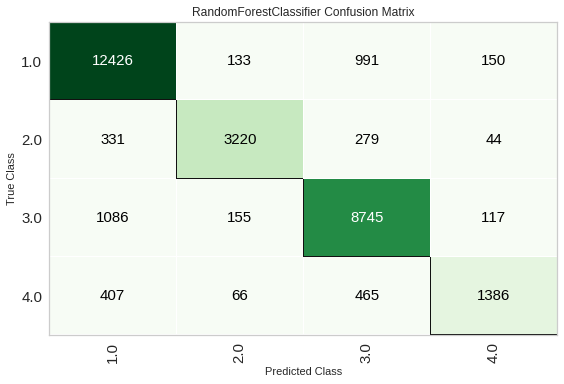

In [41]:
plot_model(rf, plot = 'confusion_matrix')

In [42]:
final_rf = finalize_model(rf)

In [43]:
test_set = df_pycaret[100000:200000]

In [45]:
predict_model(final_rf, data=test_set)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.4723,0.6532,0.3729,0.4529,0.4534,0.186,0.1889


IndexError: ignored

In [46]:
save_model(final_rf,'Final RF Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='labels',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_l